In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV


In [19]:
# Load data
features = pd.read_csv("training_set_features.csv")
labels = pd.read_csv("training_set_labels.csv")

In [20]:
# Merge features and labels
data = pd.merge(features, labels, on='respondent_id')

In [21]:
# Separate features and target variables
X = data.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])
y = data[['h1n1_vaccine', 'seasonal_vaccine']]

In [22]:
# Define categorical and numerical features
cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(exclude=['object']).columns.tolist()

In [23]:
# Preprocessing pipeline
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ])

In [24]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Define model
rf = RandomForestClassifier(random_state=42)

In [26]:
# Multilabel Classifier
multi_target_rf = MultiOutputClassifier(rf)

In [27]:
# Create pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', multi_target_rf)])


In [28]:
# Hyperparameters to tune
param_grid = {
    'classifier__estimator__n_estimators': [100, 200],
    'classifier__estimator__max_depth': [None, 10, 20],
    'classifier__estimator__min_samples_split': [2, 5, 10]
}


In [32]:
# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['age_group',
                                                                          'education',
                                                                          'race',
                                                                          'sex',
                                                                          'income_poverty',
                                                                          'marital_status',
                                                                          'rent_or_own',
                                                                          'employment_status',
                                                                          'hhs_geo_region',
                                                                          'census_...
                                                                          'opinion_seas_sick_from_vacc',
                                                                          'household_adults',
                                                                          'household_children'])])),
                                       ('classifier',
                                        MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)))]),
             n_jobs=-1,
             param_grid={'classifier__estimator__max_depth': [None, 10, 20],
                         'classifier__estimator__min_samples_split': [2, 5, 10],
                         'classifier__estimator__n_estimators': [100, 200]},
             scoring='roc_auc', verbose=2)

In [33]:
# Best parameters
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'classifier__estimator__max_depth': None, 'classifier__estimator__min_samples_split': 10, 'classifier__estimator__n_estimators': 200}


In [34]:
# Best model
best_model = grid_search.best_estimator_

In [35]:
# Evaluation
y_pred = best_model.predict_proba(X_test)
roc_auc_h1n1 = roc_auc_score(y_test['h1n1_vaccine'], y_pred[0][:, 1])

roc_auc_seasonal = roc_auc_score(y_test['seasonal_vaccine'], y_pred[1][:, 1])

overall_roc_auc = (roc_auc_h1n1 + roc_auc_seasonal) / 2

print("ROC AUC (H1N1 Vaccine): ", roc_auc_h1n1)
print("ROC AUC (Seasonal Vaccine): ", roc_auc_seasonal)
print("Overall ROC AUC: ", overall_roc_auc)

ROC AUC (H1N1 Vaccine):  0.8660344653707485
ROC AUC (Seasonal Vaccine):  0.8590657058209462
Overall ROC AUC:  0.8625500855958473


In [37]:
!pip install joblib
import joblib

In [39]:
# Save the model
import joblib
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

In [40]:
# Load test data
test_data = pd.read_csv("test_set_features.csv")

In [41]:
# Make predictions on test data
test_predictions = best_model.predict_proba(test_data)

In [42]:
# Prepare submission file
sample_submission = pd.DataFrame({
    'respondent_id': test_data['respondent_id'],
    'h1n1_vaccine': test_predictions[0][:, 1],
    'seasonal_vaccine': test_predictions[1][:, 1]
})


In [43]:
# Save submission to CSV
sample_submission.to_csv("submission.csv", index=False)

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# Load the dataset
df = pd.read_csv("test_set_features.csv")
df1 = pd.read_csv("submission.csv")

In [46]:
# Display basic statistics and structure of the dataset
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26708 entries, 0 to 26707
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26708 non-null  int64  
 1   h1n1_concern                 26623 non-null  float64
 2   h1n1_knowledge               26586 non-null  float64
 3   behavioral_antiviral_meds    26629 non-null  float64
 4   behavioral_avoidance         26495 non-null  float64
 5   behavioral_face_mask         26689 non-null  float64
 6   behavioral_wash_hands        26668 non-null  float64
 7   behavioral_large_gatherings  26636 non-null  float64
 8   behavioral_outside_home      26626 non-null  float64
 9   behavioral_touch_face        26580 non-null  float64
 10  doctor_recc_h1n1             24548 non-null  float64
 11  doctor_recc_seasonal         24548 non-null  float64
 12  chronic_med_condition        25776 non-null  float64
 13  child_under_6_mo

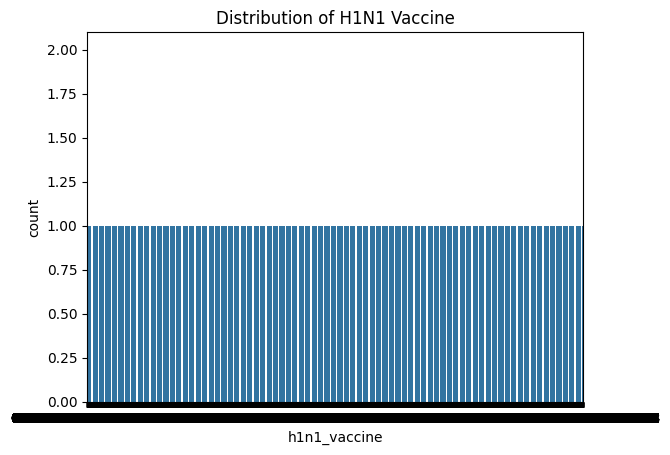

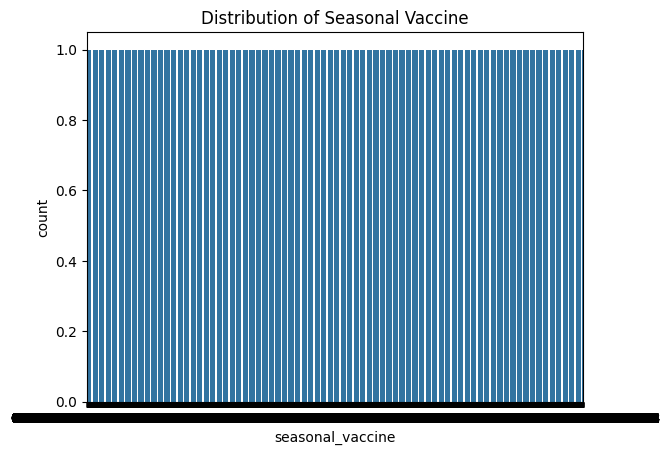

In [47]:
# Analyze the distribution of target variables
sns.countplot(x="h1n1_vaccine", data=df1)
plt.title("Distribution of H1N1 Vaccine")
plt.show()
sns.countplot(x="seasonal_vaccine", data=df1)
plt.title("Distribution of Seasonal Vaccine")
plt.show()

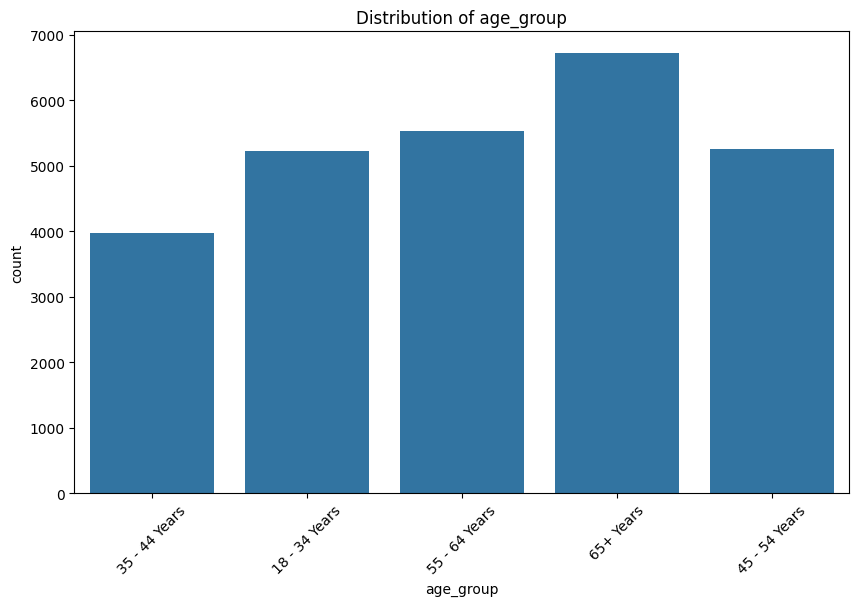

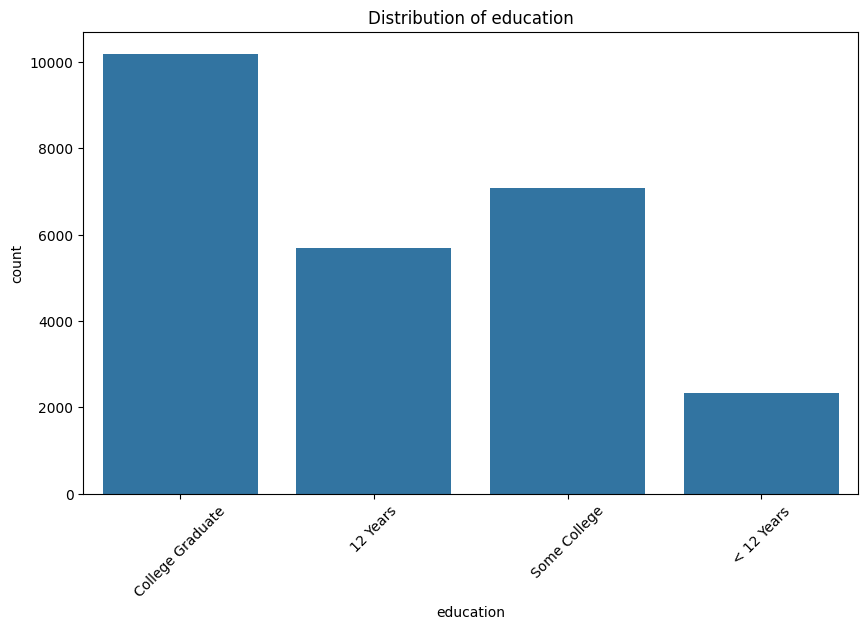

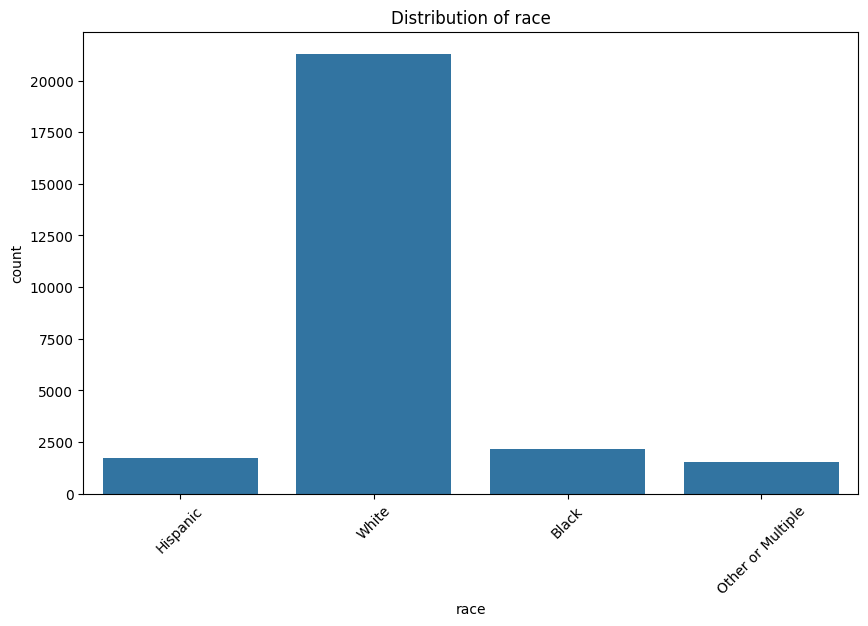

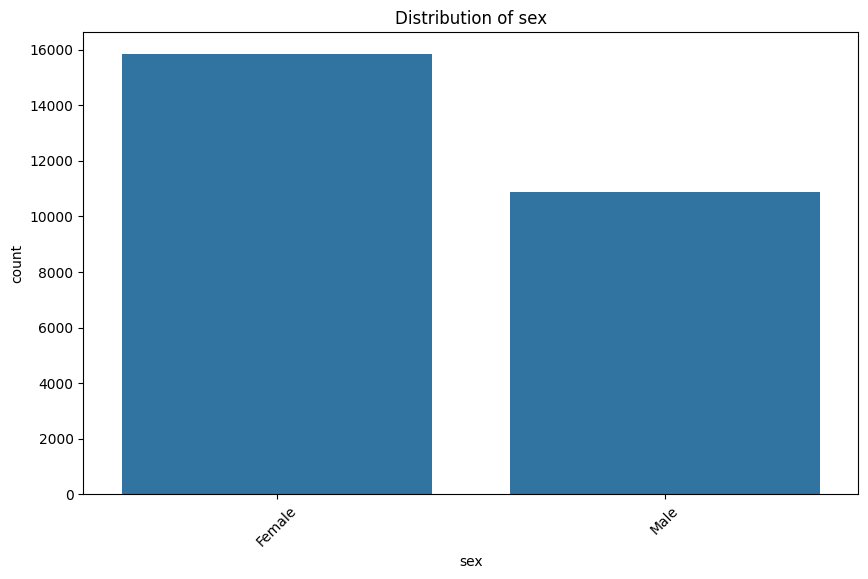

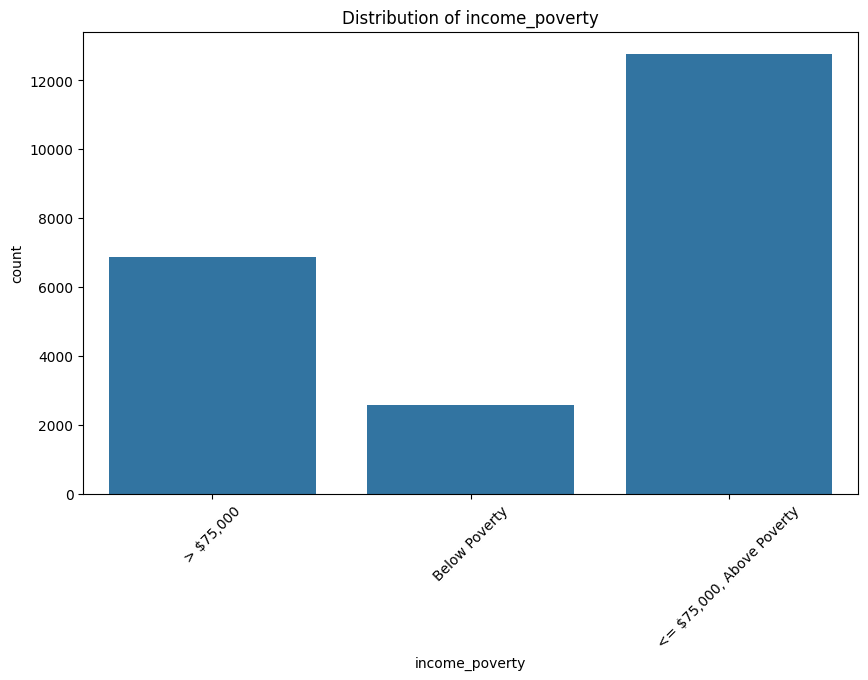

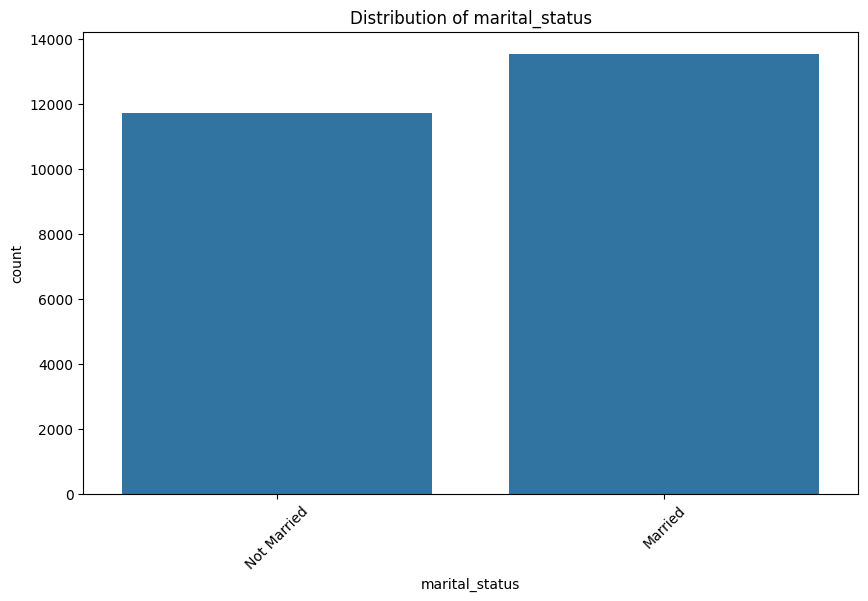

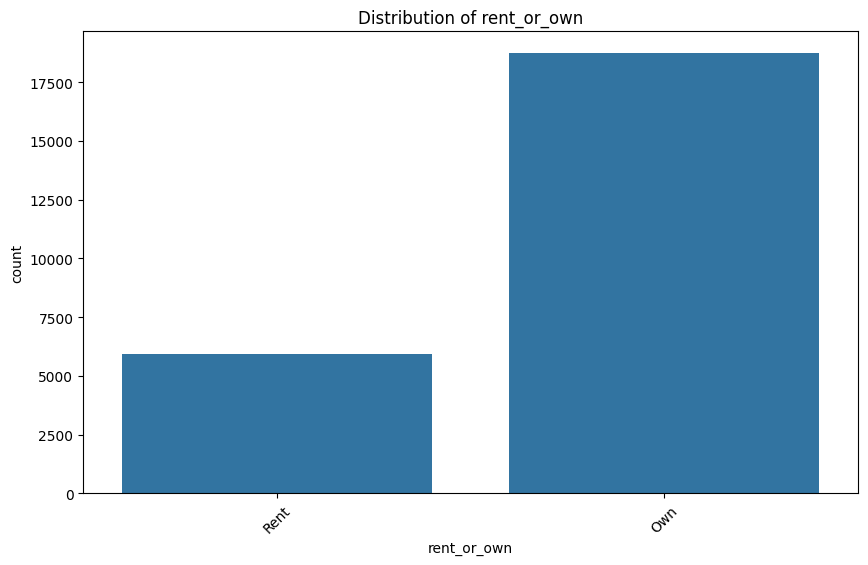

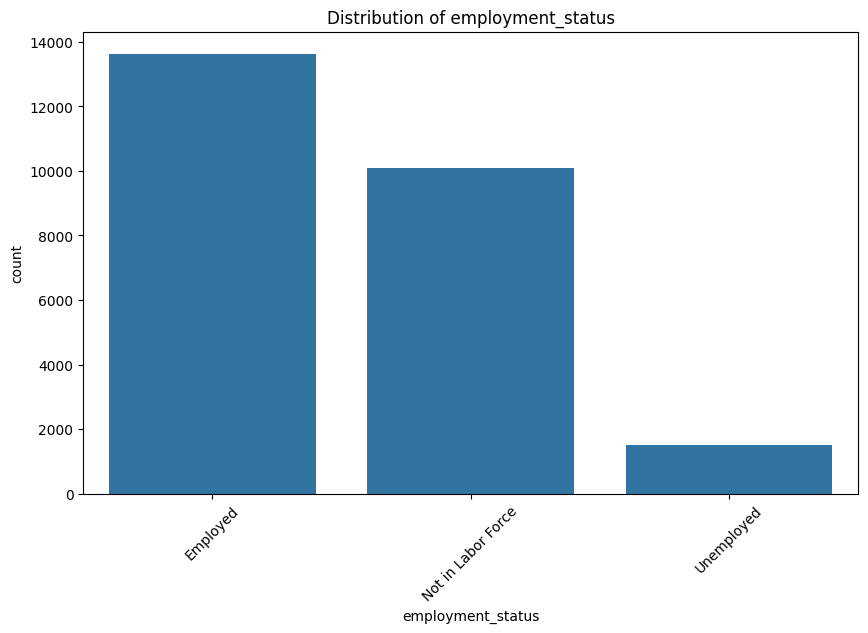

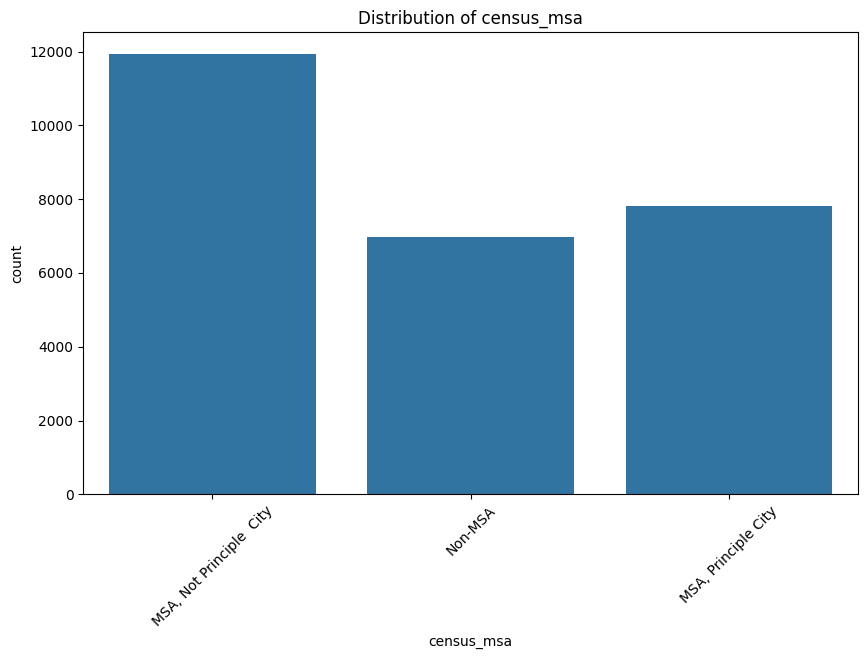

In [48]:
# Visualize the distribution of categorical features
cat_features = ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa']
for feature in cat_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, data=df)
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {feature}")
    plt.show()

In [49]:
import pandas as pd

# Assuming you have two DataFrames df1 and df2 with columns 'column1' and 'column2' respectively

# Merge the two DataFrames based on a common column
merged_df = pd.merge(df1, df, how='inner', left_on='respondent_id', right_on='respondent_id')

# Select only the columns you need from the merged DataFrame
result_df = merged_df[['h1n1_vaccine', 'h1n1_concern']]
result_df1 = merged_df[['seasonal_vaccine','opinion_seas_vacc_effective']]

# Here 'common_column_df1' and 'common_column_df2' are the columns that you want to merge on
# 'how' parameter specifies the type of join you want, 'inner' means intersection of keys from both DataFrames
result_df

,h1n1_vaccine,h1n1_concern
0,0.255249,2.0
1,0.103023,1.0
2,0.293573,2.0
3,0.585314,1.0
4,0.341712,3.0
...,...,...
26703,0.273233,1.0
26704,0.174230,3.0
26705,0.235239,0.0
26706,0.166629,3.0


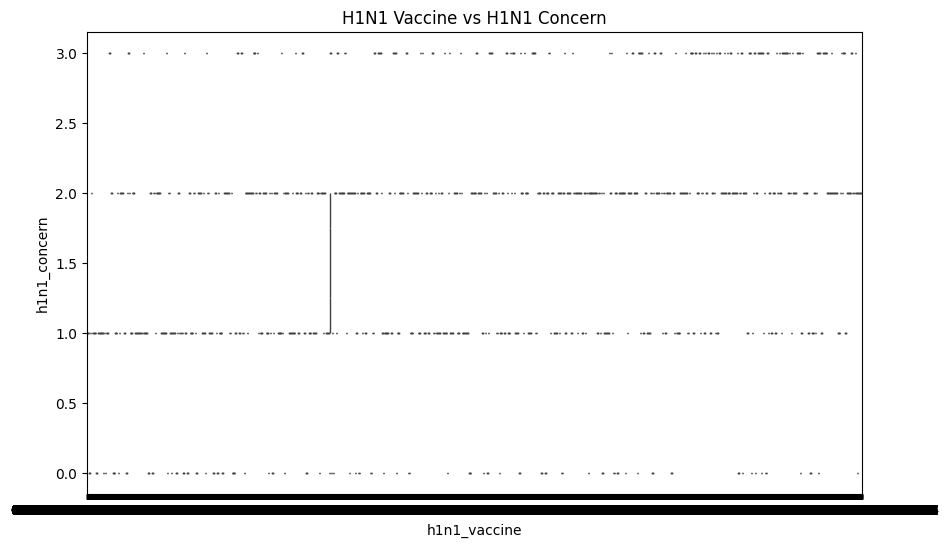

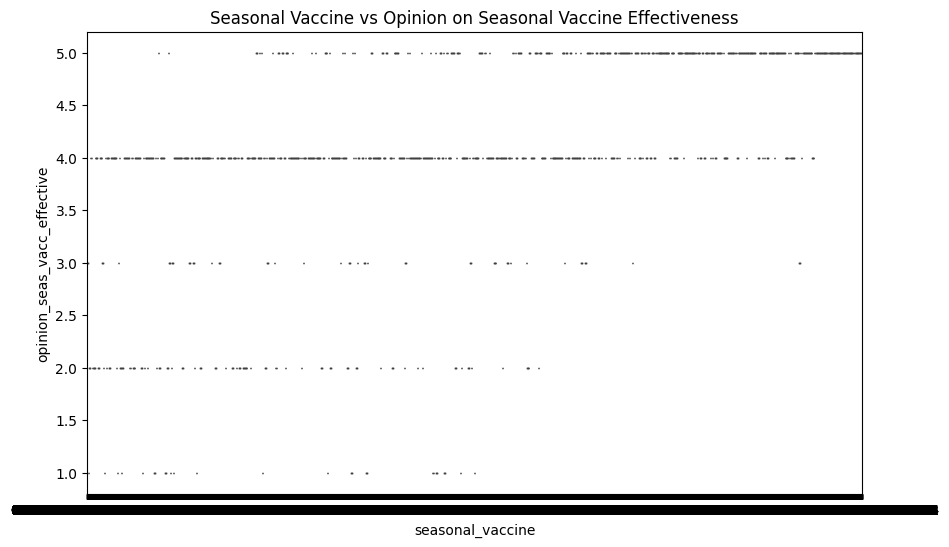

In [51]:
# Visualize the relationships between features and target variables
plt.figure(figsize=(10, 6))
sns.boxplot(x="h1n1_vaccine", y="h1n1_concern", data = result_df)
plt.title("H1N1 Vaccine vs H1N1 Concern")
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x="seasonal_vaccine", y="opinion_seas_vacc_effective", data=result_df1)
plt.title("Seasonal Vaccine vs Opinion on Seasonal Vaccine Effectiveness")
plt.show()

<ipython-input-52-d0343216c16c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")


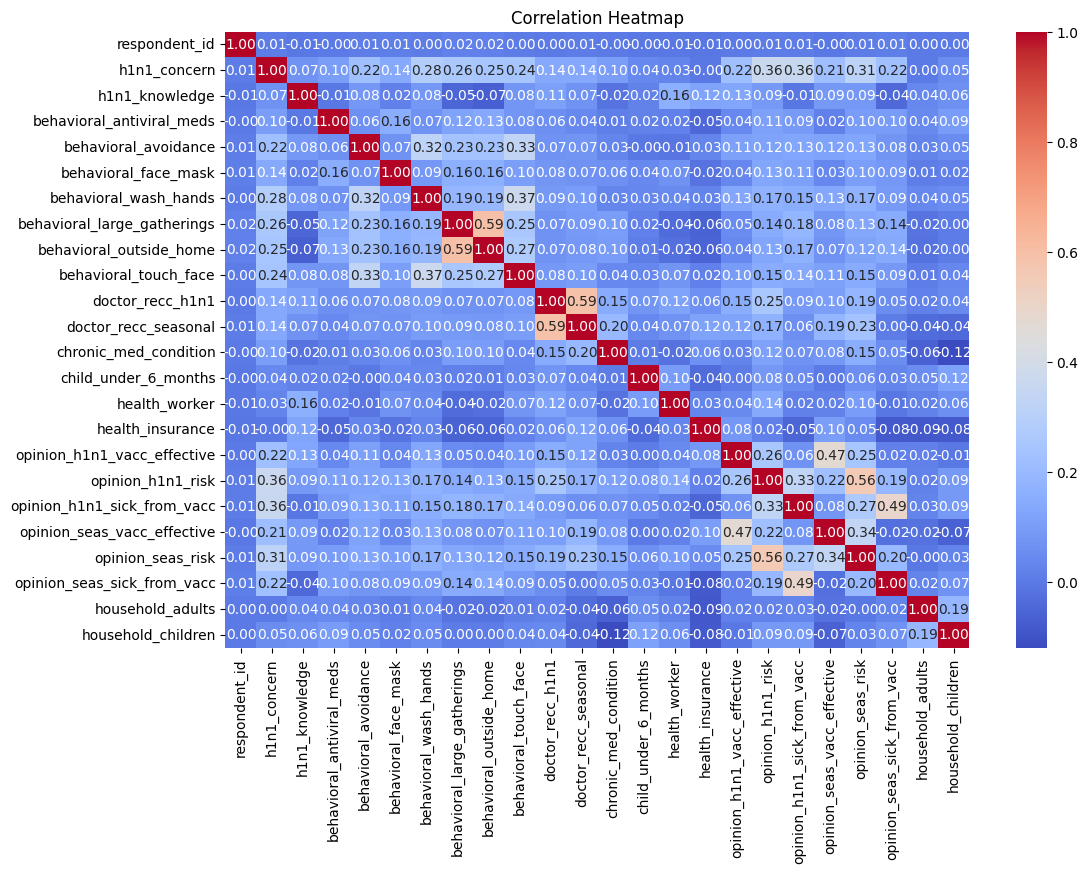

In [52]:
# Identify correlations between features
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Handle missing values and outliers if necessary
# For example, you can impute missing values or remove outliers based on domain knowledge and data exploration.

# Further exploratory data analysis and feature engineering can be performed as needed.

